# Hydrological Bias-Correction and Basin Aggregation


#### 1 Sets, indices and helpers

| Symbol                                 | Definition                                                        |
| -------------------------------------- | ----------------------------------------------------------------- |
| $S$                                    | scenario set, e.g. {\text{SSP126}, \text{SSP370}}                 |
| $B$                                    | basin set                                                         |
| $T$                                    | monthly time index from Jan 2015 ($t_0$) to Dec 2104 ($t_{1079}$) |
| $Y$                                    | yearly index $2015,\dots,2104$                                    |
| $m(t)$                                 | calendar-month of $t\in T$ (1–12)                                 |
| $\text{yr}(t)$                         | calendar-year of $t$                                              |
| $T_0$                                  | baseline window = Jan 2015 … Dec 2030                             |
| $Y^\star$                              | output years $\{2015,2020,\dots,2100\}$                           |
| $\left\langle\cdot\right\rangle_{\!A}$ | mean over index set $A$                                           |

In [6]:
import argparse
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
args = {
    "variable": "qtot",
    "gcm": "mmean",
    "isimip": "3b",
    "climmodel": "gfdl-esm4",
    "scenario": "ssp126",
    "iso3": "ZMB",
    "input_dir": Path(os.path.join("p:", "ene.model", "NEST", "ZMB", "hydrology", "isimip3B_CWatM")),
    "output_dir": Path(os.path.join("p:", "ene.model", "NEST", "ZMB", "hydrology", "isimip3B_CWatM"))
}


#### 2 Raw model data

$$
X_{s,t,b}\quad(\text{m³ s}^{-1}) ,\qquad s\in S,\; t\in T,\; b\in B .
$$


In [8]:
def load_monthly_csv(
    directory: Path, variable: str, model: str, scen: str, bool_historical = False
) -> pd.DataFrame:
    """
    Load a monthly CSV for given variable, model, and scenario,
    drop unused cols, assign datetime columns.
    """
    if not bool_historical:
        fname = directory / f"{variable}_monthly_{model}_{scen}_future.csv"
    else:
        fname = directory / f"{variable}_monthly_{model}_{scen}_historical.csv"
    df = pd.read_csv(fname).drop(
        [
            "Unnamed: 0",
            "NAME",
            "BASIN",
            "BASIN_ID",
            "area",
            "area_km2",
            "X",
            "REGION",
            "BCU_name",
        ],
        axis=1,
    )
    # assign MS frequency index
    df.columns = pd.date_range("2015-01-01", periods=df.shape[1], freq="MS")
    return df

#### 3 Baseline

##### 3.1 Scenario-specific monthly means

$$
C_{s,m,b}\;=\;\left\langle X_{s,t,b}\right\rangle_{\{t\in T_0\;:\;m(t)=m\}},\qquad m=1,\dots,12 .
$$

##### 3.2 Reference baseline (across scenarios)

$$
C^{\text{ref}}_{m,b}\;=\;\left\langle C_{s,m,b}\right\rangle_{s\in S}.
$$

##### 3.3 Reference annual mean

$$
\overline C^{\text{ref}}_{b}\;=\;\tfrac1{12}\sum_{m=1}^{12}C^{\text{ref}}_{m,b}.
$$


In [9]:
def compute_baseline(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the 2020 average baseline across
    both scenario frames over first 192 months from 2015.
    """
    rng = pd.date_range("2015-01-01", periods=192, freq="MS")
    avg1 = df1[rng].T.groupby(lambda dt: dt.month).mean().T
    avg2 = df2[rng].T.groupby(lambda dt: dt.month).mean().T
    return (avg1 + avg2) / 2

#### 4 Monthly delta fields

$$
\Delta_{s,m,b}\;=\;C_{s,m,b}-C^{\text{ref}}_{m,b}.
$$

In [10]:
def compute_deltas(
    df: pd.DataFrame, baseline: pd.DataFrame, months: int = 192
) -> pd.DataFrame:
    """
    Compute per-month delta from baseline over first 'months' months.
    """
    rng = pd.date_range("2015-01-01", periods=months, freq="MS")
    avg = df[rng].T.groupby(lambda dt: dt.month).mean().T
    return avg - baseline

#### 5 Iterative bias correction

1. **Initialization**

   $$
     Q^{(0)}_{s,t,b} \;=\; X_{s,t,b}.
   $$

2. **Anchor 2020**

   $$
     Q^{(1)}_{s,t,b}
     = 
     \begin{cases}
       C^{\rm ref}_{m(t),b}, & \text{if }\mathrm{yr}(t)=2020,\\
       Q^{(0)}_{s,t,b},     & \text{otherwise.}
     \end{cases}
   $$

3. **Five-year blocks**
   For $j=1,\dots,16$ let

   $$
     y_j = 2020 + 5j,\quad
     \delta_j = \max(1 - 0.2\,j,\,0),\quad
     W_j = \{\,t : \mathrm{yr}(t)\in[y_j-4,y_j]\}.
   $$

   Define the running-window monthly climatology

   $$
     M^{(j)}_{s,m,b}
     = \Bigl\langle Q^{(j)}_{s,t,b}\Bigr\rangle_{t\in W_j,\;m(t)=m}.
   $$

   Then set

   $$
     \widetilde M^{(j)}_{s,m,b}
     = 
     \begin{cases}
       M^{(j)}_{s,m,b}\;-\;\delta_j\,\Delta_{s,m,b}, & \delta_j>0,\\
       M^{(j)}_{s,m,b},                              & \delta_j=0,
     \end{cases}
   $$

   and update only year $y_j$:

   $$
     Q^{(j+1)}_{s,t,b}
     =
     \begin{cases}
       \widetilde M^{(j)}_{s,m(t),b}, & \mathrm{yr}(t)=y_j,\\
       Q^{(j)}_{s,t,b},               & \text{otherwise.}
     \end{cases}
   $$

4. **Final corrected field**

   $$
     Q_{s,t,b} \;=\; Q^{(17)}_{s,t,b}.
   $$

---

#### 6 Derived products

1. **Selected years** $Y^\star$:

   $$
     Q^{\rm sel}_{s,t,b}
     = 
     \begin{cases}
       Q_{s,t,b}, & \mathrm{yr}(t)\in Y^\star,\\
       \text{(omit)}, & \text{otherwise.}
     \end{cases}
   $$

2. **20-yr rolling quantiles** (window $V_t$ of the 240 months ending at $t$):

   $$
     Q^q_{p,s,t,b}
     = \operatorname{Quantile}_p\{\,Q_{s,u,b}:u\in V_t\},\quad
     p\in\{0.5,0.3,0.1\}.
   $$

3. **Five-year mean of each quantile** over non-overlapping blocks $B_k$:

   $$
     \widehat Q^{q5}_{p,s,b,k}
     = \Bigl\langle Q^q_{p,s,t,b}\Bigr\rangle_{t\in B_k},
   $$

   but for the block whose label is 2020 replace
   $\widehat Q^{q5}_{p,s,b,\text{2020}}$ by the annual baseline
   $\overline C^{\rm ref}_{b}$.


In [11]:
def bias_correction(
    df: pd.DataFrame,
    baseline: pd.DataFrame,
    delta: pd.DataFrame,
    annual_baseline: pd.Series,
    years: np.ndarray,
    multiplier_start: float = 0.8,
):
    """
    Apply bias correction fading from 2020 to 2045, then using climatology from corrected series.

    Parameters
    ----------
    df : pd.DataFrame
        Original (raw) monthly data. Columns = months (DatetimeIndex, "MS"), rows = spatial units.
    baseline : pd.DataFrame
        Baseline monthly climatology(across scenarios) for anchoring year 2020. Columns: Jan–Dec (datetime or 1–12).
    delta : pd.DataFrame
        Monthly bias corrections (same shape/order as baseline).
    annual_baseline : pd.Series
        Annual mean of the baseline
    years: List/array of target years for the monthly output. Set to 5 year blocks
    multiplier_start : float
        Initial multiplier for delta; fades out by -0.2 per 5y block.
    Returns
    -------
    df_corrected : pd.DataFrame
        Monthly bias-corrected data (2015–2104).
    df_monthly : pd.DataFrame
        Alias for df_corrected (for compatibility).
    df_5y_monthly : pd.DataFrame
        Corrected data for 5-year target years (all months).
    df_q50, df_q30, df_q10 : pd.DataFrame
        20-year rolling quantiles (0.5, 0.3, 0.1), averaged in 5-year blocks.
    """

    df = df.copy()
    # Ensure baseline and delta are indexed by month number (1–12) for easy access
    if not np.issubdtype(baseline.columns.dtype, np.integer):
        baseline.columns = baseline.columns.month if hasattr(baseline.columns, "month") else pd.to_datetime(baseline.columns).month
    if not np.issubdtype(delta.columns.dtype, np.integer):
        delta.columns = delta.columns.month if hasattr(delta.columns, "month") else pd.to_datetime(delta.columns).month

    # Set 2020 to baseline
    idx_2020 = pd.date_range("2020-01-01", periods=12, freq="MS")
    df.loc[:, idx_2020] = baseline.values

    # Fade-out bias correction: 2025–2045
    delta_mul = multiplier_start
    for year in range(2025, 2105, 5):
        assign_cols = pd.date_range(f"{year}-01-01", periods=12, freq="MS")
        lookback_cols = pd.date_range(f"{year-4}-01-01", periods=60, freq="MS")
        # Slice out the 5-year window for each spatial unit
        lookback = df.loc[:, lookback_cols]
        # Group by calendar month (1–12)
        lookback_month_means = lookback.groupby(lookback.columns.month, axis=1).mean()
        # Assign month numbers for easy join
        lookback_month_means.columns = range(1, 13)

        if delta_mul > 0.1:
            # Subtract delta*multiplier from each month in the 5-year block,
            # then compute new monthly means for the *target* year.
            block = lookback_month_means - (delta_mul * delta)
            # block: (N,12); assign to 12 months of target year
            month_map = {i: col for i, col in zip(range(1, 13), assign_cols)}
            for m in range(1, 13):
                df.loc[:, month_map[m]] = block.iloc[:, m-1]
            delta_mul -= 0.2
        else:
            # After fade-out, use the climatology from already-corrected series
            for m in range(1, 13):
                df.loc[:, month_map[m]] = lookback_month_means.iloc[:, m-1]
            # delta_mul stays at 0.0

    df_monthly = df.copy()

    # 5-year monthly (all months for specified years)
    target_cols = []
    for y in years:
        target_cols.extend(pd.date_range(f"{y}-01-01", periods=12, freq="MS"))
    target_cols = [c for c in df.columns if c in target_cols]
    df_5y_monthly = df.loc[:, target_cols]

    # Rolling 20-year quantiles (240 months), min_periods=1 (safe for edge effects)
    rolling = df_monthly.rolling(window=240, min_periods=1, axis=1)
    df_q50 = rolling.quantile(0.5).resample("5Y", axis=1, label="right", closed="right").mean()
    df_q30 = rolling.quantile(0.3).resample("5Y", axis=1, label="right", closed="right").mean()
    df_q10 = rolling.quantile(0.1).resample("5Y", axis=1, label="right", closed="right").mean()

    # Ensure 2020 annual baseline is enforced in all quantiles at block end (Dec 2020)
    dec2020 = pd.Timestamp("2020-12-31")
    for df_q in (df_q50, df_q30, df_q10):
        if dec2020 in df_q.columns:
            df_q[dec2020] = annual_baseline.values

    return df, df_monthly, df_5y_monthly, df_q50, df_q30, df_q10


##### 6.4 Environmental flow

Mean annual flow

$$
\text{MAF}_{s,y,b}=\left\langle Q_{s,t,b}\right\rangle_{\{t:\text{yr}(t)=y\}}.
$$

Monthly rule

$$
E_{s,t,b} = \begin{cases}
0.2\,Q_{s,t,b} & Q_{s,t,b}>0.8\,\text{MAF}_{s,\text{yr}(t),b}\\[2pt]
0.45\,Q_{s,t,b} & 0.4\,\text{MAF}_{s,\text{yr}(t),b}<Q_{s,t,b}\le0.8\,\text{MAF}_{s,\text{yr}(t),b}\\[2pt]
0.6\,Q_{s,t,b} & Q_{s,t,b}\le0.4\,\text{MAF}_{s,\text{yr}(t),b}
\end{cases}
$$

and take $|E_{s,t,b}|$.

Five-year means

$$
\widehat E_{s,b,k}=\left\langle E_{s,t,b}\right\rangle_{t\in B_k}.
$$

In [12]:
def environmental_flow(
    df_monthly: pd.DataFrame, years: np.ndarray
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Calculate monthly and 5-year environmental flow from monthly data.
    """
    eflow_blocks = []
    n_blocks = len(df_monthly.columns) // 12
    for b in range(n_blocks):
        start = b * 12
        block = df_monthly.iloc[:, start : start + 12].copy()
        maf = block.mean(axis=1)
        for i, col in enumerate(block.columns):
            block[col] = np.where(
                block[col] > 0.8 * maf,
                block[col] * 0.2,
                np.where(block[col] > 0.4 * maf, block[col] * 0.45, block[col] * 0.6),
            )
        eflow_blocks.append(block.abs())
    eflow_monthly = pd.concat(eflow_blocks, axis=1)
    eflow_5y = eflow_monthly.resample("5Y", axis=1).mean()
    return eflow_monthly, eflow_5y

In [13]:
def save_outputs(
    outdir: Path,
    var: str,
    iso3: str,
    df_monthly_26,
    df_5y_m_26,
    df_q50_26,
    df_q30_26,
    df_q10_26,
    df_monthly_70,
    df_5y_m_70,
    df_q50_70,
    df_q30_70,
    df_q10_70,
    eflow_monthly,
    eflow_5y,
):
    """
    Write CSV outputs with standardized filenames.
    """
    outdir.mkdir(parents=True, exist_ok=True)
    # 2p6
    df_monthly_26.to_csv(outdir / f"{var}_monthly_2p6_{iso3}.csv")
    df_5y_m_26.to_csv(outdir / f"{var}_5y_m_2p6_low_{iso3}.csv")
    df_q50_26.to_csv(outdir / f"{var}_5y_2p6_low_{iso3}.csv")
    df_q30_26.to_csv(outdir / f"{var}_5y_2p6_med_{iso3}.csv")
    df_q10_26.to_csv(outdir / f"{var}_5y_2p6_high_{iso3}.csv")
    # 7p0
    df_monthly_70.to_csv(outdir / f"{var}_monthly_7p0_{iso3}.csv")
    df_5y_m_70.to_csv(outdir / f"{var}_5y_m_7p0_low_{iso3}.csv")
    df_q50_70.to_csv(outdir / f"{var}_5y_7p0_low_{iso3}.csv")
    df_q30_70.to_csv(outdir / f"{var}_5y_7p0_med_{iso3}.csv")
    df_q10_70.to_csv(outdir / f"{var}_5y_7p0_high_{iso3}.csv")
    # environmental flow
    eflow_monthly.to_csv(outdir / f"e-flow_monthly_7p0_{iso3}.csv")
    eflow_5y.to_csv(outdir / f"e-flow_5y_7p0_{iso3}.csv")



In [20]:

var = args["variable"]
iso3 = args["iso3"]
in_dir = args["input_dir"]
out_dir = args["output_dir"]
# load
df_7p0 = load_monthly_csv(in_dir, var, "gfdl-esm4", "ssp370")
df_2p6 = load_monthly_csv(in_dir, var, "gfdl-esm4", "ssp126")
# baseline and deltas
baseline = compute_baseline(df_7p0, df_2p6)
annual_baseline = baseline.mean(axis=1)
delta_7p0 = compute_deltas(df_7p0, baseline)
delta_2p6 = compute_deltas(df_2p6, baseline)
years = np.arange(2015, 2105, 5)
# bias correction
(df_corr_2p6, df_mon_2p6, df_5y_mon_2p6, df_q50_2p6, df_q30_2p6, df_q10_2p6) = (
    bias_correction(df_2p6, baseline, delta_2p6, annual_baseline, years)
)

(df_corr_7p0, df_mon_7p0, df_5y_mon_7p0, df_q50_7p0, df_q30_7p0, df_q10_7p0) = (
    bias_correction(df_7p0, baseline, delta_7p0, annual_baseline, years)
)

# environmental flow
eflow_mon, eflow_5y = environmental_flow(df_mon_7p0, years)

In [120]:
save_outputs(
    out_dir,
    var,
    iso3,
    df_mon_2p6,
    df_5y_mon_2p6,
    df_q50_2p6,
    df_q30_2p6,
    df_q10_2p6,
    df_mon_7p0,
    df_5y_mon_7p0,
    df_q50_7p0,
    df_q30_7p0,
    df_q10_7p0,
    eflow_mon,
    eflow_5y,
)

=== Diagnostics: SSP126 ===
Sample basins: [np.int32(8), np.int32(16), np.int32(0), np.int32(18), np.int32(11), np.int32(9), np.int32(13), np.int32(1), np.int32(21), np.int32(5)]

Yearly stats:
      bias_before_mean  bias_before_std  bias_after_mean  bias_after_std  \
year                                                                       
2025           -1.8853           2.3340          -1.7091          2.0696   
2030           -0.9190           1.3669          -0.7869          1.3566   
2035            1.1626           3.9513           1.2507          3.8765   
2040            0.6934           0.8425           0.7375          0.8578   
2045            1.5828           3.3859           1.5828          3.3859   
2050           -0.4001           0.5314          -0.4001          0.5314   
2060           -0.1039           0.7808          -0.1039          0.7808   
2070            0.7027           1.0324           0.7027          1.0324   
2080           -1.5762           2.4636       

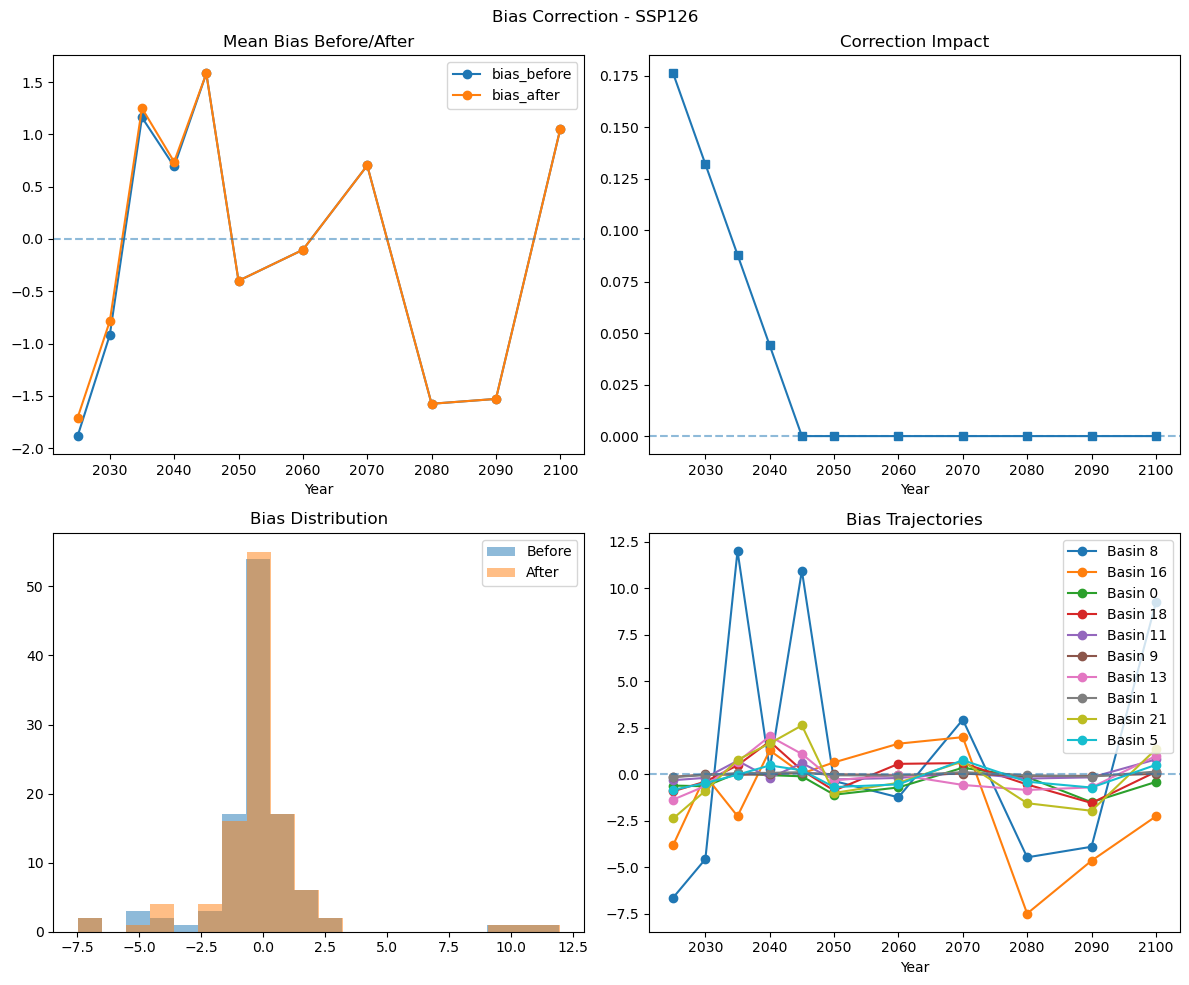

=== Diagnostics: SSP370 ===
Sample basins: [np.int32(8), np.int32(16), np.int32(0), np.int32(18), np.int32(11), np.int32(9), np.int32(13), np.int32(1), np.int32(21), np.int32(5)]

Yearly stats:
      bias_before_mean  bias_before_std  bias_after_mean  bias_after_std  \
year                                                                       
2025           -0.1384           1.7449          -0.3146          1.2640   
2030            0.2883           3.9549           0.1562          3.6300   
2035            0.5466           1.5241           0.4585          1.4319   
2040           -0.3068           1.7825          -0.3508          1.9073   
2045           -0.8801           1.3745          -0.8801          1.3745   
2050           -1.0167           2.5401          -1.0167          2.5401   
2060           -0.2939           1.4814          -0.2939          1.4814   
2070            0.9446           3.4975           0.9446          3.4975   
2080            0.0797           0.6546       

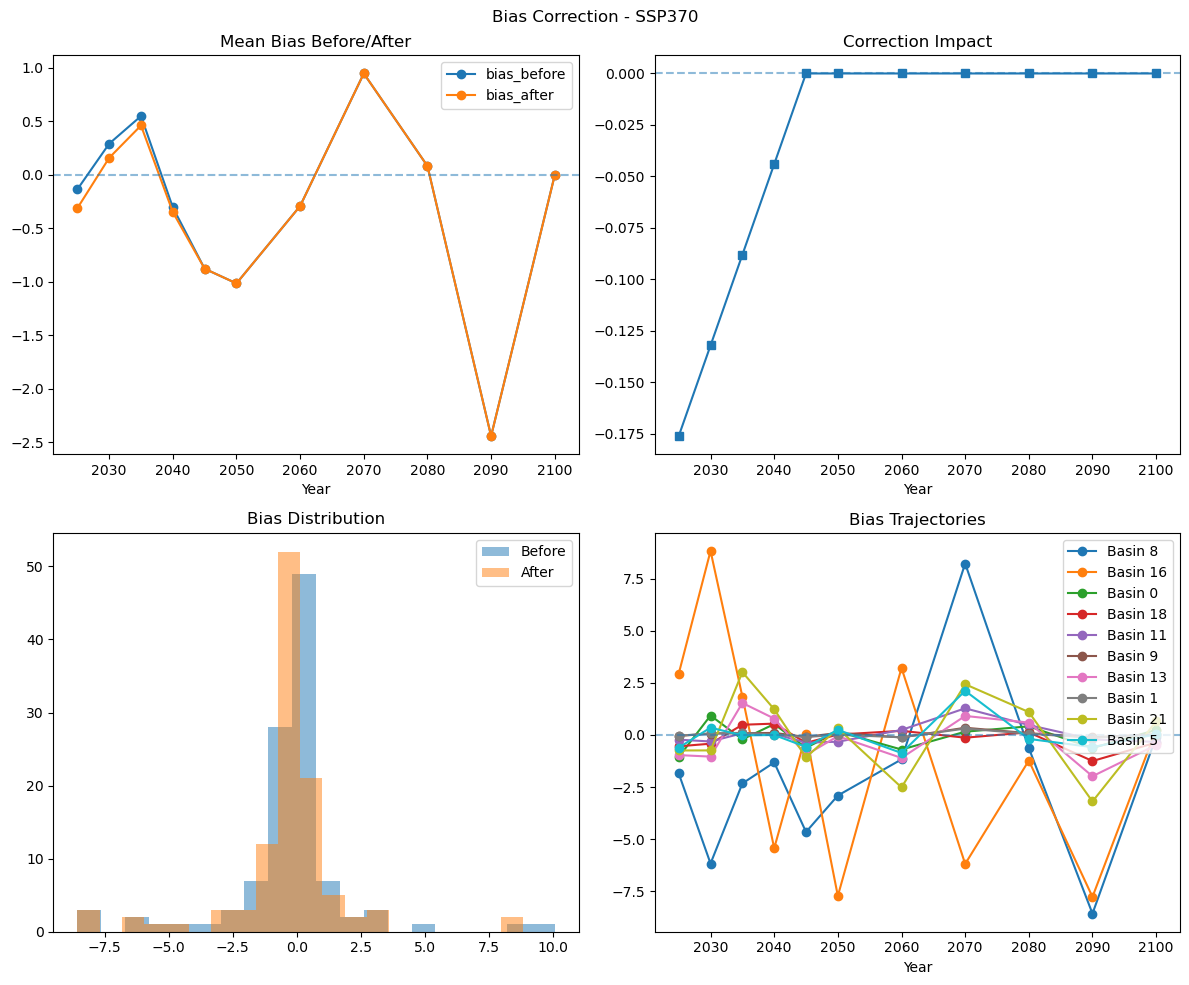

=== Scenario Comparison ===
SSP126: 0.0400
SSP370: -0.0400
Difference: 0.0801


In [134]:
def compute_yearly_stats(results_df):
    """
    Compute mean and std for bias_before, bias_after, and correction_impact by year.
    """
    stats = (
        results_df.groupby("year")
        .agg(
            bias_before_mean=("bias_before", "mean"),
            bias_before_std=("bias_before", "std"),
            bias_after_mean=("bias_after", "mean"),
            bias_after_std=("bias_after", "std"),
            impact_mean=("correction_impact", "mean"),
            impact_std=("correction_impact", "std"),
        )
        .round(4)
    )
    return stats


def summarize_overall(results_df):
    """
    Return overall mean ± std for bias_before, bias_after, and correction impact.
    """
    summary = {}
    for col in ["bias_before", "bias_after", "correction_impact"]:
        m = results_df[col].mean()
        s = results_df[col].std()
        summary[col] = (m, s)
    return summary


def bias_correction_diagnostics(
    df_orig,
    df_corr,
    baseline,
    delta,
    scenario_name,
    years=None,
    n_basins=10,
    seed=42,
):
    """
    Cleaned diagnostics: bias analysis, summary, and plots.
    """
    np.random.seed(seed)
    total = df_orig.shape[0]
    basins = np.random.choice(total, n_basins, replace=False)

    years = years or [2025, 2030, 2035, 2040, 2045, 2050, 2060, 2070, 2080, 2090, 2100]
    results = []

    for basin in basins:
        base_mean = baseline.loc[basin].mean()
        for year in years:
            cols = [c for c in df_orig.columns if c.year == year]
            if not cols:
                continue
            orig = df_orig.loc[basin, cols].mean()
            corr = df_corr.loc[basin, cols].mean()
            results.append({
                "year": year,
                "basin": basin,
                "baseline": base_mean,
                "original": orig,
                "corrected": corr,
                "bias_before": orig - base_mean,
                "bias_after": corr - base_mean,
                "correction_impact": corr - orig,
            })

    df_res = pd.DataFrame(results)
    yearly_stats = compute_yearly_stats(df_res)
    overall = summarize_overall(df_res)

    # Print diagnostics
    print(f"=== Diagnostics: {scenario_name} ===")
    print("Sample basins:", list(basins))
    print("\nYearly stats:")
    print(yearly_stats)
    print("\nOverall:")
    for k, (m, s) in overall.items():
        print(f"  {k}: {m:.4f} ± {s:.4f}")
    # bias reduction
    br = ((df_res["bias_before"].abs() - df_res["bias_after"].abs())
          / df_res["bias_before"].abs() * 100)
    print(f"Average bias reduction: {br.mean():.1f}%")

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Bias Correction - {scenario_name}")

    # 1. Bias before vs after
    stats = df_res.groupby("year")[['bias_before','bias_after']].mean()
    stats.plot(ax=axs[0,0], marker='o')
    axs[0,0].axhline(0, linestyle='--', alpha=0.5)
    axs[0,0].set(title='Mean Bias Before/After', xlabel='Year')

    # 2. Impact
    impact = df_res.groupby('year')['correction_impact'].mean()
    impact.plot(ax=axs[0,1], marker='s')
    axs[0,1].axhline(0, linestyle='--', alpha=0.5)
    axs[0,1].set(title='Correction Impact', xlabel='Year')

    # 3. Bias distribution
    axs[1,0].hist(df_res['bias_before'], bins=20, alpha=0.5, label='Before')
    axs[1,0].hist(df_res['bias_after'], bins=20, alpha=0.5, label='After')
    axs[1,0].set(title='Bias Distribution')
    axs[1,0].legend()

    # 4. Basin trajectories
    for basin in basins:
        sub = df_res[df_res['basin']==basin]
        axs[1,1].plot(sub['year'], sub['bias_after'], marker='o', label=f'Basin {basin}')
    axs[1,1].axhline(0, linestyle='--', alpha=0.5)
    axs[1,1].set(title='Bias Trajectories', xlabel='Year')
    axs[1,1].legend()

    plt.tight_layout()
    plt.show()

    return df_res


def compare_scenarios(results_dict):
    """
    Compare average correction impact across multiple scenarios.
    results_dict: {name: results_df}
    """
    print("=== Scenario Comparison ===")
    impacts = {name: df['correction_impact'].mean() for name, df in results_dict.items()}
    for name, imp in impacts.items():
        print(f"{name}: {imp:.4f}")
    vals = list(impacts.values())
    if len(vals)>1:
        print(f"Difference: {abs(vals[0]-vals[1]):.4f}")

# Example usage:
res126 = bias_correction_diagnostics(df_2p6, df_corr_2p6, baseline, delta_2p6, 'SSP126')
res370 = bias_correction_diagnostics(df_7p0, df_corr_7p0, baseline, delta_7p0, 'SSP370')
compare_scenarios({'SSP126': res126, 'SSP370': res370})
